
# Galves-Löcherbach Model

"GL model assumes that the firing of the neuron is a random event, whose probability of occurrence in any time step is a firing function Φ(V) of membrane potential V. By subsuming all sources of randomness into a single function, the Galves-Löcherbach (GL) neuron model simplifies the analysis and simulation of noisy spiking neural networks." [DOI: 10.1038/srep35831]

Reproduce the results of: Antonio Galves, Eva Löcherbach, Christophe Pouzat, Errico Presutti, "A system of interacting neurons with short term synaptic facilitation". arXiv:1903.01270v3 13 Sep 2019

Tsodyks-Markram model formally equivalent for synapse (when set to no depression, only facilitation)

Morrison A., Diesmann M., Gerstner W. (2008) Phenomenological models of synaptic plasticity based on spike timing. Biological Cybernetics 98:459–478.
DOI: 10.1007/s00422-008-0233-1.


Preliminaries
-------------

In [1]:
%matplotlib inline
from typing import Dict, Optional

import matplotlib as mpl

mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5

import matplotlib.pyplot as plt

import nest
import numpy as np
import os
import random

from pynestml.frontend.pynestml_frontend import generate_nest_target

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

In [2]:
def fI_curve(neuron_model: str, t_stop: float = 1000., custom_model_opts: Optional[Dict] = None):
    I_stim_vec = np.linspace(0, 1E-9, 40)  # [A]
    rate = float("nan") * np.ones_like(I_stim_vec)

    for i, I_stim in enumerate(I_stim_vec):
        nest.ResetKernel()
        neuron = nest.Create(neuron_model, params=custom_model_opts)

        dc = nest.Create("dc_generator", params={"amplitude": 1E12 * I_stim})  # 1E12: convert A to pA
        nest.Connect(dc, neuron)

#         multimeter = nest.Create('multimeter')
#         nest.SetStatus(multimeter, {"record_from": ["U"]})
#         nest.Connect(multimeter, neuron)

        sr = nest.Create('spike_recorder')
        nest.Connect(neuron, sr)

        nest.Simulate(t_stop)

#         Vms = multimeter.events["U"]
#         ts = multimeter.events["times"]

        rate[i] = sr.n_events / t_stop * 1000
    
    return I_stim_vec, rate

Normalized model with calcium dynamics
---------------------------------------------------

The `R` variable represents the calcium concentration of the presynaptic neuron. For convenience (and at the cost of some redundancy), we store it here in the NEST synapse object.

In [3]:
nestml_gl_ca_synapse_model = '''
synapse syn_gl_ca:
  state:
    R_pre real = 0.

  parameters:
    the_delay ms = 1 ms  @nest::delay   # !!! cannot have a variable called "delay"
    lmbda real = 2.1555489309487914   # residual calcium decay rate

  onReceive(incoming_spikes):
    R_pre += 1
    deliver_spike(R_pre - 1, the_delay)

  input:
    incoming_spikes real <- spike
  
  output:
    spike
  
  update:
    R_pre *= exp(-lmbda * 1E-3 * resolution())   # leakage
'''

Neuron:

In [4]:
nestml_gl_ca_neuron_model = '''
neuron gl_ca:
  state:
    U real = 0     # membrane potential

  parameters:
    a real = 3.
    alpha_over_N real = 1.0777744654743957   # synaptic strength
    beta real = 50     # membrane potential leak
    reset_after_spike boolean = true

  input:
    incoming_spikes real <- spike

  output:
    spike

  function phi(U real) real:
    if U <= 0:
      return 0

    #tmp real = (4 * a) / (1 + exp(a - U)) - (4 * a) / (1 + exp(a))
    #println("phi({U}) = {tmp}")
    return (4 * a) / (1 + exp(a - U)) - (4 * a) / (1 + exp(a))

  equations:
    kernel K = delta(t)
    
    # R is presynaptic neuron's R and is passed as the spike weight by the synapse
    U' = -U / (1E3/beta) + alpha_over_N * convolve(K, incoming_spikes) / ms

  update:
    # integrate spike input
    integrate_odes()

    # emit spike?
    if random_uniform(0, 1) <= 1E-3 * resolution() * phi(U):
      emit_spike()
      if reset_after_spike:
          U = 0   # reset membrane potential
'''

In [5]:
with open("nestml_gl_ca_synapse_model.nestml", "w") as nestml_model_file:
    print(nestml_gl_ca_synapse_model, file=nestml_model_file)

with open("nestml_gl_ca_model.nestml", "w") as nestml_model_file:
    print(nestml_gl_ca_neuron_model, file=nestml_model_file)

generate_nest_target(input_path=["nestml_gl_ca_model.nestml", "nestml_gl_ca_synapse_model.nestml"],
                     target_path="/tmp/nestml-gl-ca-target",
                     module_name="nestml_gl_ca_module",
                     suffix="_nestml",
                     logging_level="DEBUG"#WARNING  # try "INFO" for more debug information
                    )

[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /home/charl/julich/gl_neuron/nestml_gl_ca_model.nestml
[3,GLOBAL, INFO]: /home/charl/julich/gl_neuron/nestml_gl_ca_synapse_model.nestml
[4,GLOBAL, INFO]: Target platform code will be generated in directory: '/tmp/nestml-gl-ca-target'
[5,GLOBAL, INFO]: Start processing '/home/charl/julich/gl_neuron/nestml_gl_ca_model.nestml'!
[6,gl_ca_nestml, DEBUG, [2:0;40:0]]: Start building symbol table!
[7,gl_ca_nestml, WARNING, [7:4;7:13]]: Variable 'a' has the same name as a physical unit!
[8,gl_ca_nestml, WARNING, [27:4;30:4]]: Variable 'K' has the same name as a physical unit!
[9,gl_ca_nestml, INFO, [20:13;20:13]]: Implicit casting from (compatible) type 'integer' to 'real'.
[10,gl_ca_nestml, WARNING, [30:9;30:23]]: Implicit casting from (compatible) type '1 / ms' to 'real'.
[11,gl_ca_nestml, INFO, [4:13;4:13]]: Implicit casting from (compatible) type 'integer' to 'real'.
[12,gl_ca_nestml, INFO, [9:16;9:16]]: Implicit cast

INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "U' = (-U) / (1000.0 / beta) + alpha_over_N * 0 / 1.0",
            "initial_values": {
                "U": "0"
            }
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "a": "3.0",
        "alpha_over_N": "1.0777744654743957",
        "beta": "50",
        "reset_after_spike": "true"
    }
}
INFO:Processing global options...
INFO:Processing input shapes...
INFO:
Processing differential-equation form shape U with defining expression = "(-U) / (1000.0 / beta) + alpha_over_N * 0 / 1.0"
DEBUG:Splitting expression -0.001*U*beta (symbols [U])
DEBUG:	linear factors: Matrix([[-0.001*beta]])
DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: 0.0
DEBUG:Created Shape with symbol U, derivative_factors = [-0.001*beta], inhom_term = 0.0, nonlin_term = 0.0
INFO:	Returning shape: Shape "U" of order 1
INFO:Shape U: reconstituting expression -0.001*U*be

[33,syn_gl_ca_nestml, INFO, [11:13;11:13]]: Implicit casting from (compatible) type 'integer' to 'real'.
[34,GLOBAL, INFO]: Analysing/transforming neuron 'gl_ca_nestml'
[35,gl_ca_nestml, INFO, [2:0;40:0]]: Starts processing of the model 'gl_ca_nestml'


INFO:Saving dependency graph plot to /tmp/ode_dependency_graph.dot
DEBUG:write 88 bytes to '/tmp/ode_dependency_graph.dot'
DEBUG:run ['dot', '-Kdot', '-Tpdf', '-O', 'ode_dependency_graph.dot']
INFO:Generating propagators for the following symbols: U
DEBUG:Initializing system of shapes with x = Matrix([[U]]), A = Matrix([[-0.001*beta]]), b = Matrix([[0.0]]), c = Matrix([[0]])
INFO:In ode-toolbox: returning outdict = 
INFO:[
    {
        "initial_values": {
            "U": "0"
        },
        "parameters": {
            "beta": "50.0000000000000"
        },
        "propagators": {
            "__P__U__U": "1.0*exp(-0.001*__h*beta)"
        },
        "solver": "analytical",
        "state_variables": [
            "U"
        ],
        "update_expressions": {
            "U": "U*__P__U__U"
        }
    }
]


[36,gl_ca_nestml, DEBUG, [2:0;40:0]]: Start building symbol table!
[37,gl_ca_nestml, INFO, <ADDED_BY_SOLVER>]: Implicit casting from (compatible) type 'ms' to 'real'.
[38,gl_ca_nestml, WARNING, [7:4;7:13]]: Variable 'a' has the same name as a physical unit!
[39,gl_ca_nestml, INFO, [20:13;20:13]]: Implicit casting from (compatible) type 'integer' to 'real'.
[40,gl_ca_nestml, INFO, [9:16;9:16]]: Implicit casting from (compatible) type 'integer' to 'real'.
[41,gl_ca_nestml, INFO, [40:14;40:14]]: Implicit casting from (compatible) type 'integer' to 'real'.
[42,GLOBAL, INFO]: Analysing/transforming synapse syn_gl_ca_nestml.
[43,syn_gl_ca_nestml, INFO, [2:0;21:0]]: Starts processing of the model 'syn_gl_ca_nestml'
[44,GLOBAL, INFO]: Rendering template /tmp/nestml-gl-ca-target/gl_ca_nestml.cpp
[45,GLOBAL, INFO]: Rendering template /tmp/nestml-gl-ca-target/gl_ca_nestml.h
[46,gl_ca_nestml, INFO, [2:0;40:0]]: Successfully generated code for the model: 'gl_ca_nestml' in: '/tmp/nestml-gl-ca-target

In [6]:
nest.Install("nestml_gl_ca_module")


### Postsynaptic response

Note that due to the residual calcium dynamics, the synapse is facilitating.

The decay should correspond to the $\beta$ parameter.

When a neuron spikes, it increases the potential of each postsynaptic partner by $\alpha R/N$.

In [7]:
def measure_postsynaptic_response(neuron_model: str,
                                  synapse_model: str,
                                  t_stop: float = 2250.,
                                  V_m_specifier: str = "V_m",
                                  custom_model_opts: Optional[Dict] = None):
    spike_times = np.array([100., 200., 250., 2000.])

    nest.ResetKernel()
    neuron = nest.Create(neuron_model, params=custom_model_opts)
    neuron.alpha_over_N = 1E-6   # a very low value, to prevent the neuron from spiking
    #dc = nest.Create("dc_generator", params={"amplitude": 1E12 * I_stim})  # 1E12: convert A to pA
    #nest.Connect(dc, neuron)
    spike_generator = nest.Create("spike_generator", params={"spike_times": spike_times})
    nest.Connect(spike_generator, neuron, syn_spec={'synapse_model': synapse_model})

    multimeter = nest.Create('multimeter')
    nest.SetStatus(multimeter, {"record_from": [V_m_specifier]})
    nest.Connect(multimeter, neuron)

    sr = nest.Create('spike_recorder')
    nest.Connect(neuron, sr)

    nest.Simulate(t_stop)

    ts = multimeter.events["times"]
    Vms = multimeter.events[V_m_specifier]
    
    return ts, Vms

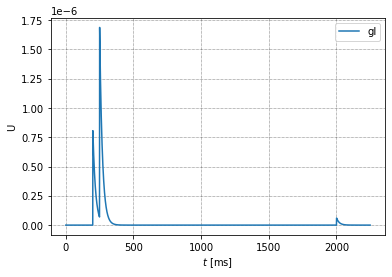

In [8]:
ts, Vms_gl = measure_postsynaptic_response("gl_ca_nestml", "syn_gl_ca_nestml", V_m_specifier="U")

fig, ax = plt.subplots()
ax.set_xlabel("$t$ [ms]")
ax.plot(ts, Vms_gl, label="gl")
ax.set_ylabel("U")
ax.legend()

### Firing rate

This should correspond to the Phi(U) function in the neuron (see plot below for the theoretical curve).

In [9]:
nest.ResetKernel()
nest.resolution = 1.   # check that results are independent of resolution...

a = 3.

t_stop = 25000.

U_range = np.linspace(0., 10., 12)
n_spikes = np.nan * np.ones_like(U_range)
for i, U in enumerate(U_range):
    neuron = nest.Create("gl_ca_nestml", params={"reset_after_spike": False})
    neuron.beta = 1E-99   # a very low value, to prevent the membrane potential from decaying
    neuron.U = U
    neuron.a = a

    sr = nest.Create('spike_recorder')
    nest.Connect(neuron, sr)

    nest.Simulate(t_stop)

    n_spikes[i] = len(sr.events["times"])

spike_rate = n_spikes / (t_stop / 1E3)

In [10]:
_U = np.linspace(0., 10., 100)
Phi_of_U = (4 * a) / (1 + np.exp(a - _U)) - (4 * a) / (1 + np.exp(a))

Text(0, 0.5, 'Firing rate [Hz]')

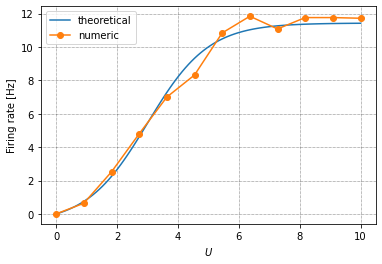

In [11]:
fig, ax = plt.subplots()
ax.plot(_U, Phi_of_U, label="theoretical")
ax.set_xlabel("$U$")

ax.plot(U_range, spike_rate, marker="o", label="numeric")
ax.legend()
ax.set_xlabel("$U$")
ax.set_ylabel("Firing rate [Hz]")

### Network dynamics

In [12]:
foo=None
def run_simulation_in_chunks(sim_chunks, sim_time, syn_recordables, neurons):
    global foo
    sim_time_per_chunk = sim_time / sim_chunks

    # Init log to collect the values of all recordables
    log = {}
    log["t"] = []

    # Initialize all the arrays
    # Additional one entry is to store the trace value before the simulation begins
    for rec in syn_recordables:
        log[rec] = (sim_chunks + 1) * [[]]

    # Get the value of trace values before the simulation
    syn = nest.GetConnections(target=neurons, synapse_model="syn_gl_ca_nestml")
    print(str(len(syn)) + " synapses in the network")
    foo=syn
    for rec in syn_recordables:
        log[rec][0] = syn.get(rec)
        
    log["t"].append(nest.GetKernelStatus("biological_time"))

    # Run the simulation in chunks
    for i in range(sim_chunks):
        sim_start_time = i * sim_time_per_chunk
        sim_end_time = sim_start_time + sim_time_per_chunk

        nest.Simulate(np.round(sim_time/sim_chunks))
        
        # log current values
        log["t"].append(nest.GetKernelStatus("biological_time"))

        # Get the value of trace after the simulation
        for rec in syn_recordables:
            log[rec][i + 1] = syn.get(rec).copy()
            
    #nest.Cleanup()
    
    return log


In [42]:
N = 100      # Number of neurons in network XXX: 1000 in the original paper
conn_prob = 1.

a = 2.

beta = 50.
lmbda = 10.
alpha = beta * lmbda

U_0 = 1.#0.79555   # initial membrane potential
R_0 = .2#1.   # initial residual calcium

U_range = .1 * U_0
R_range = .1 * R_0

In [63]:
nest.ResetKernel()
nest.resolution = .1 # [ms]

sim_time = 500.   # [ms] XXX: 120 second original paper
chunk_length = 10.   # [ms]
n_chunks = int(sim_time / chunk_length)
syn_recordables = ["R_pre"]

pop = nest.Create("gl_ca_nestml", N)
pop.a = a
pop.alpha_over_N = alpha / N
pop.beta = beta
pop.U = [U_0 + U_range * (random.random() - .5) for _ in range(N)]

conn_spec_dict = {'rule': 'pairwise_bernoulli', 'p': conn_prob, 'allow_autapses': False}
nest.Connect(pop, pop, conn_spec_dict, syn_spec={'synapse_model': 'syn_gl_ca_nestml', 'lmbda': lmbda})

#syn_recordables = []
#nest.Connect(pop, pop, conn_spec_dict, syn_spec={'synapse_model': 'static_synapse'})


syn = nest.GetConnections(target=pop, synapse_model="syn_gl_ca_nestml")
N_syn = len(syn)
syn.R_pre = [R_0 + R_range * (random.random() - .5) for _ in range(N_syn)]

multimeter = nest.Create("multimeter")
multimeter.set({"record_from": ["U"], "interval": nest.resolution})
nest.Connect(multimeter, pop)

sr = nest.Create('spike_recorder')
nest.Connect(pop, sr)

log = run_simulation_in_chunks(n_chunks, sim_time, syn_recordables, pop)


"""nest.Simulate(sim_time)

neuron_ids = np.unique(multimeter.get("events")["senders"])

fig, ax = plt.subplots(nrows=2)

U_avg = np.zeros(len(np.unique( multimeter.get("events")["times"])))
# R_avg = np.zeros_like(U_avg)
for neuron_id in range(1, N+1):
    idx = np.where(neuron_id == multimeter.get("events")["senders"])
    times = multimeter.get("events")["times"][idx]
    U = multimeter.get("events")["U"][idx]
    #R = multimeter.get("events")["R"][idx]
    
    U_avg += U / N
    #R_avg += R / N

    if neuron_id < 100:
        ax[0].plot(U, label="U")
#         ax[1].plot(R, label="R")

ax[0].plot(U_avg, linewidth=4, linestyle="--", c="black")
ax[0].set_ylabel("U")
# ax[1].plot(R_avg, linewidth=4, linestyle="--", c="black")
ax[1].set_ylabel("R")

for _ax in ax:
    _ax.set_xlim(0, sim_time)
ax[-1].set_xlabel("Time [ms]")"""

9900 synapses in the network


'nest.Simulate(sim_time)\n\nneuron_ids = np.unique(multimeter.get("events")["senders"])\n\nfig, ax = plt.subplots(nrows=2)\n\nU_avg = np.zeros(len(np.unique( multimeter.get("events")["times"])))\n# R_avg = np.zeros_like(U_avg)\nfor neuron_id in range(1, N+1):\n    idx = np.where(neuron_id == multimeter.get("events")["senders"])\n    times = multimeter.get("events")["times"][idx]\n    U = multimeter.get("events")["U"][idx]\n    #R = multimeter.get("events")["R"][idx]\n    \n    U_avg += U / N\n    #R_avg += R / N\n\n    if neuron_id < 100:\n        ax[0].plot(U, label="U")\n#         ax[1].plot(R, label="R")\n\nax[0].plot(U_avg, linewidth=4, linestyle="--", c="black")\nax[0].set_ylabel("U")\n# ax[1].plot(R_avg, linewidth=4, linestyle="--", c="black")\nax[1].set_ylabel("R")\n\nfor _ax in ax:\n    _ax.set_xlim(0, sim_time)\nax[-1].set_xlabel("Time [ms]")'

Text(0.5, 0.98, 'R')

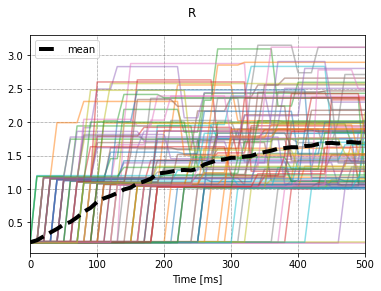

In [64]:
times = log["t"]
R_pre = np.array(log["R_pre"])
R_pre_avg = np.mean(R_pre, axis=1)


fig, ax = plt.subplots()
ax.plot(times, R_pre[:, ::N], alpha=.5)   # XXX: plot only every N-th line
ax.set_xlim(0, sim_time)
ax.set_xlabel("Time [ms]")
ax.plot(times, R_pre_avg, linewidth=4, linestyle="--", c="black", label="mean")
ax.legend()
fig.suptitle("R")

Text(0, 0.5, 'Neuron')

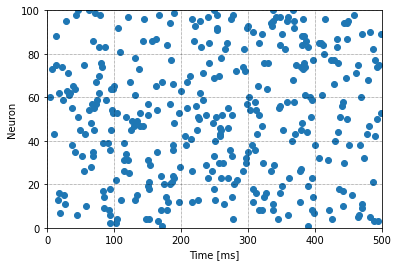

In [65]:
fig, ax = plt.subplots()
ax.scatter(sr.events["times"], sr.events["senders"])
ax.set_ylim(0, N)
ax.set_xlim(0, sim_time)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Neuron")

In [66]:
avg_firing_rate = len(sr.events["times"]) / N / (sim_time / 1E3)
print("Network average firing rate: " + str(avg_firing_rate) + " Hz")

Network average firing rate: 7.22 Hz


Text(0.5, 0.98, 'U')

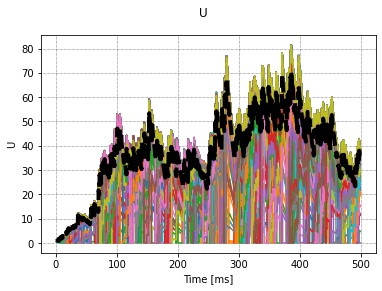

In [67]:
neuron_ids = np.unique(multimeter.get("events")["senders"])

fig, ax = plt.subplots()

U_avg = np.zeros(len(np.unique(multimeter.get("events")["times"])))
for neuron_id in range(1, N+1):
    idx = np.where(neuron_id == multimeter.get("events")["senders"])
    times = multimeter.get("events")["times"][idx]
    U = multimeter.get("events")["U"][idx]
    
    U_avg += U / N

    if neuron_id < 100:
        ax.plot(times, U, label="U")

ax.plot(times, U_avg, linewidth=4, linestyle="--", c="black")
ax.set_ylabel("U")
ax.set_xlabel("Time [ms]")
fig.suptitle("U")

### Comparison to theory

(0.01, 6)

DEBUG:vmin 0.1 vmax 150.00000000000003
DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
DEBUG:vmin 0.1 vmax 150.00000000000003
DEBUG:ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6.e-02, 7.e-02, 8.e-02, 9.e-02,
       2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01, 9.e-01,
       2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00, 7.e+00, 8.e+00, 9.e+00,
       2.e+01, 3.e+01, 4.e+01, 5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01,
       2.e+02, 3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02,
       2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03, 9.e+03,
       2.e+04, 3.e+04, 4.e+04, 5.e+04, 6.e+04, 7.e+04, 8.e+04, 9.e+04])
DEBUG:vmin 0.1 vmax 150.00000000000003
DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
DEBUG:vmin 0.1 vmax 150.00000000000003
DEBUG:ticklocs array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])
DEBUG:vmin 0.1 vmax 150.00000000000003
DEBUG:ticklocs array([2.e-02, 3.e-02, 4.e-02, 5.e-02, 6

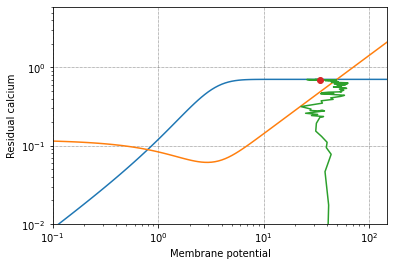

In [74]:
def phi(x):
    return (4 * a) / (1 + np.exp(a - x)) - (4 * a) / (1 + np.exp(a))

def nullcline1(x):
    return phi(x)/lmbda

def nullcline2(x):
    return beta/alpha*x/phi(x)

U_vec = np.logspace(np.log10(.1), np.log10(150), 100)

nullcline1_vec = nullcline1(U_vec)
nullcline2_vec = nullcline2(U_vec)

fig, ax = plt.subplots()
ax.loglog(U_vec, nullcline1_vec)
ax.loglog(U_vec, nullcline2_vec)

U_avg_intrp = np.interp(np.linspace(0, len(U_avg), 100),
                        np.arange(len(U_avg)),
                        U_avg)

R_pre_intrp = np.interp(np.linspace(0, len(R_pre_avg), 100),
                        np.arange(len(R_pre_avg)),
                        R_pre_avg)

R_pre_intrp[ R_pre_intrp <= 1] = 1.000001

#ax.loglog(U_avg[::200], R_pre_avg[:50] - 1)
ax.loglog(U_avg_intrp, R_pre_intrp - 1)
ax.loglog(U_avg[-1], R_pre_avg[-1] - 1, marker="o")

#ax.scatter(U_avg[:199], R_pre_avg[:199])

ax.set_xlabel('Membrane potential')
ax.set_ylabel('Residual calcium')
ax.set_xlim(np.amin(U_vec), np.amax(U_vec))
ax.set_ylim(.01, 6)

#ax.plot(U_avg, R_avg)

In [75]:
R_pre_intrp

array([1.000001  , 1.000001  , 1.000001  , 1.000001  , 1.000001  ,
       1.000001  , 1.000001  , 1.000001  , 1.000001  , 1.000001  ,
       1.000001  , 1.000001  , 1.000001  , 1.000001  , 1.000001  ,
       1.000001  , 1.000001  , 1.000001  , 1.000001  , 1.000001  ,
       1.000001  , 1.000001  , 1.000001  , 1.000001  , 1.000001  ,
       1.000001  , 1.000001  , 1.000001  , 1.00300352, 1.01745214,
       1.04660356, 1.07771535, 1.0945982 , 1.11059174, 1.13160081,
       1.1537244 , 1.19368034, 1.2296995 , 1.23619288, 1.24299194,
       1.25121745, 1.25996716, 1.27042049, 1.27861199, 1.28137508,
       1.28204592, 1.27888097, 1.28195025, 1.2939256 , 1.31626105,
       1.3502516 , 1.37491056, 1.39127477, 1.40875991, 1.4270297 ,
       1.43653067, 1.44124865, 1.45098255, 1.46280642, 1.46616047,
       1.46690843, 1.47431492, 1.48314824, 1.48885841, 1.49415215,
       1.51117633, 1.52893365, 1.54096831, 1.55291985, 1.56354141,
       1.57463788, 1.5892962 , 1.60229652, 1.60755957, 1.61317

## Acknowledgements

...


## References

...


## Copyright

This file is part of NEST.

Copyright (C) 2004 The NEST Initiative

NEST is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

NEST is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with NEST.  If not, see <http://www.gnu.org/licenses/>.
